https://stepik.org/media/attachments/lesson/396012/hw_aa.csv

 Описание задачи
 
А/А-тестирование мобильного приложения: проверка системы сплитования (разделения на группы) перед А/В тестом.
Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR ( - доля ложных положительных классификаций (False Positive Rate)), будем проверять на конверсии в покупку. 

Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины
 

Описание колонок

    experimentVariant – вариант эксперимента
    version – версия приложения
    purchase – факт покупки

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm  #  визуальная индикация хода вычислений. Обновляемый progressbar для программ на Python

In [2]:
hw_aa = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')

In [3]:
hw_aa.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
hw_aa.nunique()

Unnamed: 0           127018
uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

In [5]:
hw_aa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


In [6]:
hw_aa.experimentVariant.unique()

array([1, 0], dtype=int64)

In [7]:
hw_aa.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [8]:
hw_aa.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [9]:
hw_aa.purchase.unique()

array([0, 1], dtype=int64)

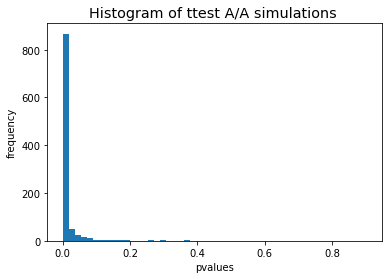

0.938

In [10]:
# Запуск симуляций A/A теста  (https://www.experiment-fest.ru/)
# вариант:  подвыборки без возвращения объемом 1000 

simulations = 1000
n_s = 1000
res = []
for i in tqdm(range(simulations)):                             #   повторяем 1000 раз
    s1 = hw_aa.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values  #  подвыборка 0 варианта      
    s2 = hw_aa.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values  #  подвыборка 1 варианта
  
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])  #  сохраняем p-value t-testа в массив, 
                                                               #  Н0: подвыборки "не различаются"
    
# строим гистограмму Т-теста по симуляции: частота встречающихся значений p-value
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа (FPR  <  alfa)
sum(np.array(res) < 0.05) / simulations

Большинство полученных значений  p-value < 0.05 (это видно на гистограмме) => количество ложноположительных случаев **ПРЕВЫШАЕТ альфа**

#### 0.943 > alfa.     Группы разделены не корректно.

Пытаемся исправить:
    
    Посчитаем конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно 
    причины поломки
    Посчитаем pvalue для каждой версии МП
    Найдём версии, где pvalue < 0.05 (т.е.  выборки различаются)
    Исключим версию с pvalue < 0.05 из основного датафрейма
    Повторно запустим расчет FPR через A/A. Теперь FPR < альфа
    Мы нашли поломку

#### Посчитаем конверсию в покупку зависимости от версии Мобильного Приложения

In [11]:
hw_aa.query('experimentVariant == 0 and purchase == 1').version.value_counts()/ \
    hw_aa.query('experimentVariant == 0').version.value_counts()*100

v2.8.0      0.099314
v2.9.0      7.465817
v3.7.4.0    5.994291
v3.8.0.0    5.760450
Name: version, dtype: float64

In [12]:
hw_aa.query('experimentVariant == 1 and purchase == 1').version.value_counts()/ \
    hw_aa.query('experimentVariant == 1').version.value_counts()*100

v2.8.0      4.560551
v2.9.0      7.130391
v3.8.0.0    6.284779
v3.7.4.0    6.301824
Name: version, dtype: float64

МП v2.8.0 показывает очень различные результаты, сильное отличие конверсий: v2.8.0  ---    0.099314 и 4.560551

<AxesSubplot:xlabel='experimentVariant', ylabel='purchase'>

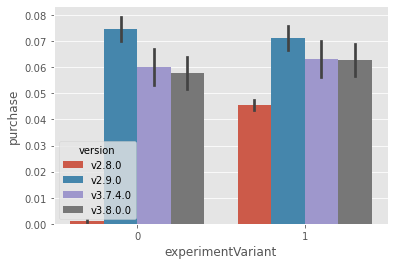

In [13]:
import seaborn as sns
sns.barplot(data=hw_aa, x = 'experimentVariant', y = 'purchase', hue ='version')

<AxesSubplot:xlabel='version', ylabel='count'>

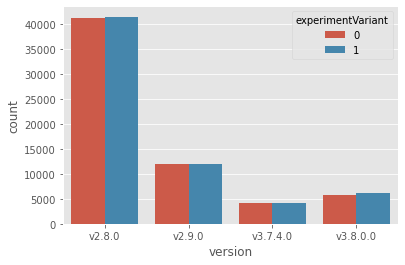

In [14]:
sns.countplot(data=hw_aa,  x ='version', hue = 'experimentVariant')

<AxesSubplot:xlabel='version', ylabel='count'>

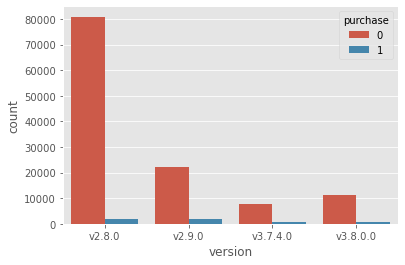

In [15]:
sns.countplot(data=hw_aa,  x ='version', hue = 'purchase')

У версии 2.8.0 пропорции по количеству версий в группах соблюдены, но с продажами **дисбаланс**

Проверим выборки на p-value по версиям отдельно: Используем Т-тест (одна переменная номинативная, вторая как-бы количественная).

Нулевая гипотеза: выборки статистически не различаются

In [16]:
x1 = hw_aa.query('experimentVariant == 0 and version == "v2.8.0"').purchase
x2 = hw_aa.query('experimentVariant == 1 and version == "v2.8.0"').purchase
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-43.09705159855106, pvalue=0.0)

#### version == "v2.8.0"  выборки  различаются

In [17]:
x1 = hw_aa.query('experimentVariant == 0 and version == "v2.9.0"').purchase
x2 = hw_aa.query('experimentVariant == 1 and version == "v2.9.0"').purchase
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=0.997860971925487, pvalue=0.31835686930247525)

version == "v2.9.0" выборки похожи

In [18]:
x1 = hw_aa.query('experimentVariant == 0 and version == "v3.8.0.0"').purchase
x2 = hw_aa.query('experimentVariant == 1 and version == "v3.8.0.0"').purchase
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-1.1973368830477646, pvalue=0.23119934317948818)

version == "v3.8.0.0" выборки похожи

In [19]:
x1 = hw_aa.query('experimentVariant == 0 and version == "v3.7.4.0"').purchase
x2 = hw_aa.query('experimentVariant == 1 and version == "v3.7.4.0"').purchase
stats.ttest_ind(x1, x2, equal_var = False)

Ttest_indResult(statistic=-0.5875202960070302, pvalue=0.556870078412284)

version == "v3.7.4.0" выборки похожи

 #### Попробуем провести А/А тест без МП version == "v2.8.0"

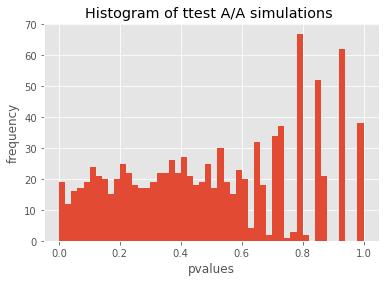

0.039

In [20]:
# Запуск симуляций A/A теста
simulations = 1000
n_s = 1000
res = []
for i in tqdm(range(simulations)):
    s1 = hw_aa.query('experimentVariant == 0 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = hw_aa.query('experimentVariant == 1 and version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа (FPR  <  alfa)
sum(np.array(res) < 0.05) / simulations

Теперь А/А  группы корректны.

Выводы:

изначально разделение на группы было проведено формально верно (количество каждой версии в каждом наборе), 
но не совсем корректно.          
МП версии 2.8.0 сильно отличается по конверсии между контролем и тестом. Что показал и p-value.
Если убрать МП версии 2.8.0 из контрольной и тестовой групп, деление получается более честым. И можно воспользоваться этой системой сплитования для эксперимента.
 
